## Simulation as Optimization: Finding Paths of Least Action with Gradient Descent
Tim Strang and Sam Greydanus | 2023 | MIT License

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch, time

from celluloid import Camera
from IPython.display import HTML
from base64 import b64encode

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from main import * # SimOpt code

In [4]:
def plot_action_stats(ax, S, T, V, S_ode, T_ode, V_ode):
    plot_config = [(S, 'k', '$S$'), (T, 'r', '$\sum_i T_i$'), (-np.asarray(V), 'b', '$-\sum_i V_i$'),
                   (S_ode, 'k:', '$S$ (ODE)'), (T_ode, 'r:', '$-\sum_i T_i$ (ODE)'),
                   (-V_ode, 'b:', '$-\sum_i V_i$ (ODE)')]
    N = len(S)
    for i, (x, fmt, label) in enumerate(plot_config):
        if i <= 2:
            ax.plot(np.arange(N), x, fmt, linewidth=4, label=label)
        else:
            ax.plot([0,N], [x]*2, fmt, linewidth=4, label=label)
            
def plot_helper(ax, ax_labels):
    plt.title(ax_labels['title'], fontweight="bold")
    plt.legend(ncol=2)
    plt.xlabel(ax_labels['x_label'])
    plt.ylabel(ax_labels['y_label'])
    for item in [ax.xaxis.label, ax.yaxis.label]:
        item.set_fontsize(23)
    ax.title.set_fontsize(19)
    ax.tick_params(axis='both', length=9, width=3, labelsize=15)
    plt.tight_layout()  # helps clean up plots sometimes
    
def action_plot(info, x_sim, ax_labels, L_fn, fig=None):
    if fig is None:
        fig = plt.figure(figsize=(8.3333, 6.25), dpi=50)
    ax = fig.add_subplot(111)
    S_ode, T_ode, V_ode = action(torch.tensor(x_sim), L_fn=L_fn, dt=dt)
    plot_action_stats(ax, info['S'], info['T'], info['V'], S_ode, T_ode.sum(), V_ode.sum())

    plot_helper(ax, ax_labels)
    return fig

## Free body

In [5]:
t_sim, x_sim = simulate_freebody(dt=0.25, steps=60)
# plt.title('Free body') ; plt.plot(t_sim, x_sim, 'k.-') ; plt.show()

In [6]:
dt = 0.25 ; N = 1 ; steps = 60
t_sim, x_sim = simulate_freebody(dt=dt, steps=steps)
init_path = PerturbedPath(x_sim, N=N, coords=1, sigma=1.5e0, zero_basepath=True) # [time, N*2]
t_min, path, xs_min, info = minimize_action(init_path, steps=500, step_size=1e0, 
                                       L_fn=lagrangian_freebody, dt=dt, opt='adam', print_updates=3)

step=0000, S=4.868e+01 J*s, E_loss=0.000e+00, dt=0.0s
step=0166, S=-1.153e+01 J*s, E_loss=0.000e+00, dt=0.1s
step=0332, S=-1.390e+01 J*s, E_loss=0.000e+00, dt=0.1s
step=0498, S=-1.399e+01 J*s, E_loss=0.000e+00, dt=0.1s


In [7]:
# plt.figure(dpi=90)
# plt.title('Particle in freefall')
# plt.plot(t_sim, x_sim, 'r-', label='ODE solution')

# plt.plot(t_min, xs_min[0], 'y.-', label='Initial (random) path')
# for i, xi in enumerate(xs_min):
#     label = 'During optimization' if i==10 else None
#     plt.plot(t_min, xi, alpha=0.3, color=plt.cm.viridis( 1-i/(len(xs_min)-1) ), label=label)
# plt.plot(t_min, xs_min[-1], 'b.-', label='Final (optimized) path')
# plt.plot(t_min[[0,-1]], xs_min[0].data[[0,-1]], 'b+', markersize=15, label='Points held constant')

# plt.ylim(-5, 40)
# plt.xlabel('Time (s)') ; plt.ylabel('Height (m)') ; plt.legend(fontsize=8, ncol=3)
# plt.tight_layout() ; plt.show()

./static/freebody_action.pdf


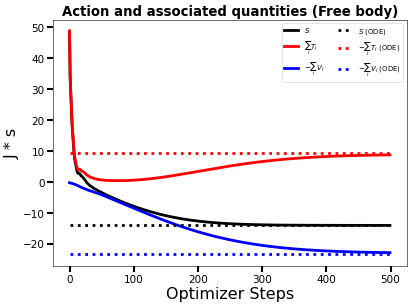

In [8]:
name = 'Free body'
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fig = action_plot(info, x_sim, ax_labels, L_fn=lagrangian_freebody)
path ='./static/{}_action.pdf'.format(name.lower().replace(' ', '')) ; print(path)
plt.show() #; fig.savefig(path)

## Single pendulum

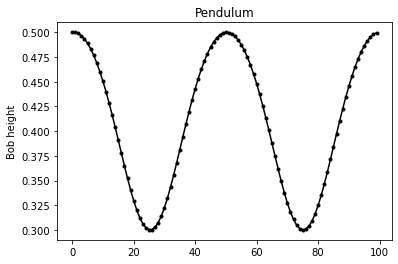

In [9]:
dt = 1
t_sim, x_sim = simulate_pend(dt=dt)

xy = radial2cartesian_pend(x_sim)
plt.title('Pendulum') ; plt.ylabel('Bob height')
plt.plot(t_sim, xy[:,0,1], 'k.-') ; plt.show()

make_video(xy, path='sim.mp4', interval=60, ms=20)
mp4 = open('sim.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

step=0000, S=4.913e+02 J*s, E_loss=1.670e+04, dt=0.0s
step=0666, S=1.906e+01 J*s, E_loss=1.529e+01, dt=0.3s
step=1332, S=-1.592e+01 J*s, E_loss=2.096e-01, dt=0.3s
step=1998, S=-1.627e+01 J*s, E_loss=2.301e-02, dt=0.3s


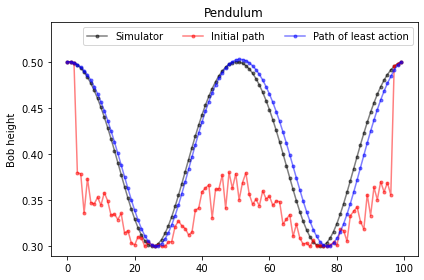

In [10]:
dt = 1 ; N = 1
t_sim, x_sim = simulate_pend(dt=dt)

init_path = PerturbedPath(x_sim, N=N, coords=1, sigma=3.0e-1, zero_basepath=False) # [time, N*2]
init_path.x.data[3:-3] = init_path.x.data[3:-3] * 0.5
t_min, path, xs_min, info = minimize_action(init_path, steps=2000, step_size=2e-2, L_fn=lagrangian_pend,
                                            dt=dt, opt='adam', print_updates=3, e_coeff=1e2) #1e-3

plt.title('Pendulum') ; plt.ylabel('Bob height')
plt.plot(t_sim, radial2cartesian_pend(x_sim)[...,1], 'k.-', alpha=0.5, label='Simulator')
plt.plot(t_min, radial2cartesian_pend(xs_min[0])[...,1], 'r.-', alpha=0.5, label='Initial path')
plt.plot(t_min, radial2cartesian_pend(xs_min[-1])[...,1], 'b.-', alpha=0.5, label='Path of least action')
plt.legend(loc='upper right', ncol=3)
plt.ylim(None, radial2cartesian_pend(xs_min[-1])[...,1].max() + 0.04)
plt.tight_layout() ; plt.show()

./static/pendulum_action.pdf


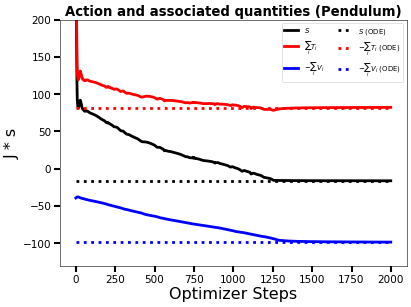

In [11]:
name = 'Pendulum'
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fig = action_plot(info, x_sim, ax_labels, L_fn=lagrangian_pend)
plt.ylim(None, 200)
path ='./static/{}_action.pdf'.format(name.lower().replace(' ', '')) ; print(path)
plt.show() #; fig.savefig(path)

In [12]:
make_video(radial2cartesian_pend(xs_min[-1]), path='sim.mp4', interval=60, ms=20)
mp4 = open('sim.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

## Double pendulum

In [13]:
from main import * # SimOpt code

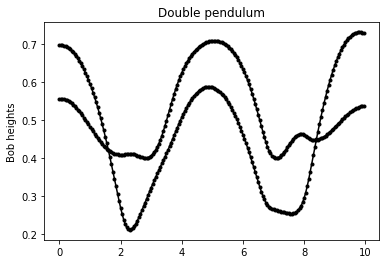

In [14]:
t_sim, x_sim = simulate_dblpend(dt=0.05)
cart_coords = radial2cartesian_dblpend(x_sim)
plt.title('Double pendulum') ; plt.ylabel('Bob heights')
plt.plot(t_sim, cart_coords[:,:,1], 'k.-') ; plt.show()

make_video(cart_coords, path='sim.mp4', interval=30, ms=20)
mp4 = open('sim.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

step=0000, S=1.991e+02 J*s, E_loss=2.025e+06, dt=0.0s
step=3000, S=3.667e+00 J*s, E_loss=1.264e+01, dt=1.7s
step=6000, S=3.399e+00 J*s, E_loss=1.671e+00, dt=1.6s
step=9000, S=3.293e+00 J*s, E_loss=3.726e-01, dt=1.6s
step=12000, S=3.198e+00 J*s, E_loss=1.617e-01, dt=1.6s
step=15000, S=2.908e+00 J*s, E_loss=6.611e-02, dt=1.6s
step=18000, S=2.657e+00 J*s, E_loss=3.936e-02, dt=1.6s
step=21000, S=2.638e+00 J*s, E_loss=9.588e-03, dt=1.6s
step=24000, S=2.621e+00 J*s, E_loss=7.186e-03, dt=1.6s
step=27000, S=2.594e+00 J*s, E_loss=5.463e-03, dt=1.6s


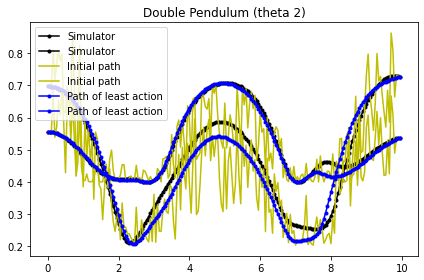

In [15]:
dt = 0.05 ; N = 2
t_sim, x_sim = simulate_dblpend(dt=dt)

init_path = PerturbedPath(x_sim, N=N, coords=1, sigma=7e-1, zero_basepath=False) # [time, N*2]
k = 40
init_path.x.data[k:-k] = init_path.x.data[k:-k] * 0.75
t_min, path, xs_min, info = minimize_action(init_path, steps=30000, step_size=1e-2, L_fn=lagrangian_dblpend,
                                            dt=dt, opt='adam', print_updates=10, e_coeff=1e6) # 1e2


plt.title('Double Pendulum (theta 2)')
plt.plot(t_sim, radial2cartesian_dblpend(x_sim)[:,:,1], 'k.-', label='Simulator')
plt.plot(t_min, radial2cartesian_dblpend(xs_min[0])[:,:,1], 'y-', label='Initial path')
plt.plot(t_min, radial2cartesian_dblpend(xs_min[-1])[:,:,1], 'b.-', label='Path of least action')
plt.legend()
plt.tight_layout() ; plt.show()

make_video(radial2cartesian_dblpend(xs_min[-1]), path='sim.mp4', interval=60, ms=20)
mp4 = open('sim.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

./static/doublependulum_action.pdf


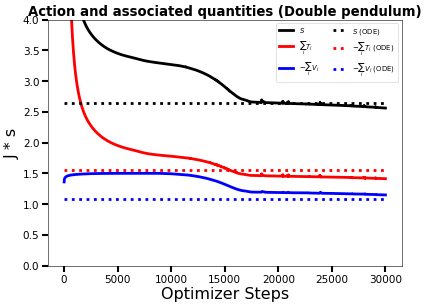

In [16]:
name = 'Double pendulum'
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fig = action_plot(info, x_sim, ax_labels, L_fn=lagrangian_dblpend)
plt.ylim(0, 4)
path ='./static/{}_action.pdf'.format(name.lower().replace(' ', '')) ; print(path)
plt.show() #; fig.savefig(path)

step=0000, S=9.832e+01 J*s, E_loss=6.903e+04, dt=0.0s
step=3333, S=3.626e+00 J*s, E_loss=3.623e-01, dt=1.8s
step=6666, S=2.758e+00 J*s, E_loss=6.347e-02, dt=1.7s
step=9999, S=2.513e+00 J*s, E_loss=4.496e-03, dt=1.7s
./static/doublependulum_action.pdf


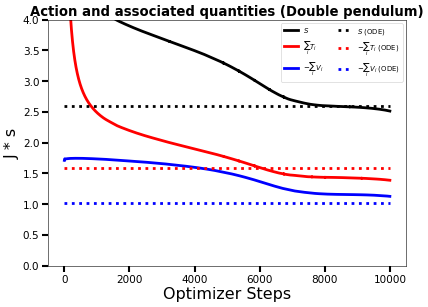

In [17]:
dt = 0.06 ; N = 2
t_sim, x_sim = simulate_dblpend(dt=dt)

init_path = PerturbedPath(x_sim, N=N, coords=1, sigma=7e-1, zero_basepath=False) # [time, N*2]
k = 40
init_path.x.data[k:-k] = init_path.x.data[k:-k] * 0.5
t_min, path, xs_min, info = minimize_action(init_path, steps=10000, step_size=2e-2, L_fn=lagrangian_dblpend,
                                            dt=dt, opt='adam', print_updates=3, e_coeff=1e5) # 1e2


name = 'Double pendulum'
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fig = action_plot(info, x_sim, ax_labels, L_fn=lagrangian_dblpend)
plt.ylim(0, 4)
path ='./static/{}_action.pdf'.format(name.lower().replace(' ', '')) ; print(path)
plt.tight_layout() ; plt.show() #; fig.savefig(path)

step=0000, S=1.904e+02 J*s, E_loss=0.000e+00, dt=0.0s
step=0500, S=2.622e+00 J*s, E_loss=0.000e+00, dt=0.3s
step=1000, S=2.583e+00 J*s, E_loss=0.000e+00, dt=0.3s
./static/doublependulum_action.pdf


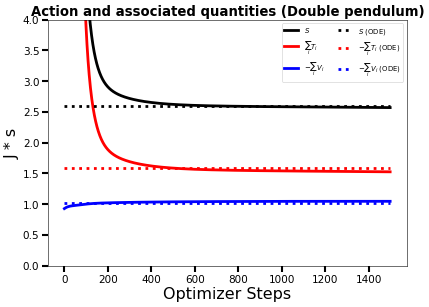

In [18]:
dt = 0.06 ; N = 2
t_sim, x_sim = simulate_dblpend(dt=dt)

init_path = PerturbedPath(x_sim, N=N, coords=1, sigma=7e-1, zero_basepath=False) # [time, N*2]
t_min, path, xs_min, info = minimize_action(init_path, steps=1500, step_size=1e-2, L_fn=lagrangian_dblpend,
                                            dt=dt, opt='adam', print_updates=3, e_coeff=0) # 1e2


name = 'Double pendulum'
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fig = action_plot(info, x_sim, ax_labels, L_fn=lagrangian_dblpend)
plt.ylim(0, 4)
path ='./static/{}_action.pdf'.format(name.lower().replace(' ', '')) ; print(path)
plt.tight_layout() ; plt.show() #; fig.savefig(path)

## Three body problem

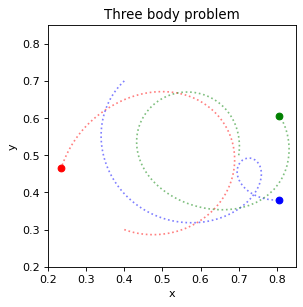

In [19]:
def plot_3body(x, do_bodies=False, colors=None, fig=None, fmt='-', **kwargs):
    if fig is None:
        plt.figure(figsize=[4,4], dpi=80)
    if not colors:
        colors = ['red', 'blue', 'green']
    plt.title('Three body problem') ; plt.xlabel('x') ; plt.ylabel('y')
    for i, c in enumerate(colors):
        plt.plot(x[:,i,0], x[:,i,1], fmt, color=c, **kwargs)
        if do_bodies:
            plt.plot(x[-1,i,0], x[-1,i,1], '.', color=c, markersize=12)
    plt.xlim(0.2,0.85) ; plt.ylim(0.2,0.85)
    #plt.xlim(0,1) ; plt.ylim(0,1)

t, x_sim = simulate_3body(stable_config=False)
plot_3body(x_sim, do_bodies=True, fmt=':', alpha=0.5)

In [20]:
make_video(x_sim, path='sim.mp4', interval=60, ms=10)
mp4 = open('sim.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

In [28]:
dt = 0.5 ; N = 3

t_sim, x_sim = simulate_3body(dt=dt, stable_config=False)
init_path = PerturbedPath(x_sim, N=N, sigma=3e-2) # [time, N*2]
# init_path.x.data[3:-3,0] = init_path.x.data[3:-3,0] * 0.6 + 0.3
t_min, path, xs_min, info = minimize_action(init_path, steps=200, step_size=1e-3, L_fn=lagrangian_3body,
                                            dt=dt, opt='adam', print_updates=10, e_coeff=0)

step=0000, S=4.117e-03 J*s, E_loss=0.000e+00, dt=0.0s
step=0020, S=8.692e-04 J*s, E_loss=0.000e+00, dt=0.5s
step=0040, S=5.845e-04 J*s, E_loss=0.000e+00, dt=0.6s
step=0060, S=5.518e-04 J*s, E_loss=0.000e+00, dt=0.6s
step=0080, S=5.420e-04 J*s, E_loss=0.000e+00, dt=0.5s
step=0100, S=5.374e-04 J*s, E_loss=0.000e+00, dt=0.6s
step=0120, S=5.339e-04 J*s, E_loss=0.000e+00, dt=0.6s
step=0140, S=5.308e-04 J*s, E_loss=0.000e+00, dt=0.6s
step=0160, S=5.279e-04 J*s, E_loss=0.000e+00, dt=0.6s
step=0180, S=5.251e-04 J*s, E_loss=0.000e+00, dt=0.5s


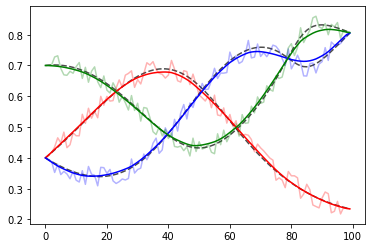

In [29]:
fig, ax1 = plt.subplots()
ax1.set_prop_cycle(color=['red', 'blue', 'green'])

plt.plot(x_sim[:,:,0], 'k--', alpha=0.7)
plt.plot(xs_min[0][:,::2], '-', alpha=0.3)
plt.plot(xs_min[-1][:,::2], '-', alpha=1)
plt.show()

./static/threebody_action.pdf


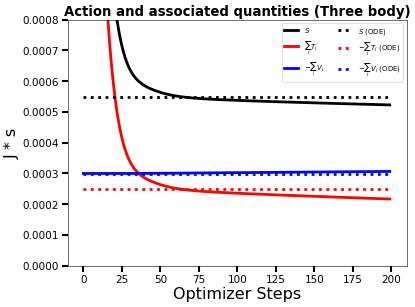

In [30]:
name = 'Three body'
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fig = action_plot(info, x_sim, ax_labels, L_fn=lagrangian_3body)
plt.ylim(0, 0.0008)
path ='./static/{}_action.pdf'.format(name.lower().replace(' ', '')) ; print(path)
plt.show() #; fig.savefig(path)

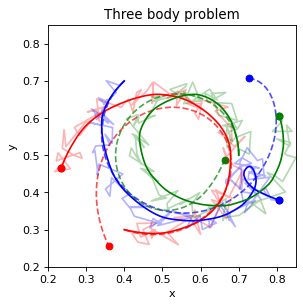

In [31]:
t, x = simulate_3body()

fig = plt.figure(figsize=[4,4], dpi=80)
colors = ['black', 'black', 'black']
plot_3body(x, fig=fig, do_bodies=True, fmt='--', alpha=0.7)
plot_3body(xs_min[0].reshape(-1,3,2), fig=fig, do_bodies=True, fmt='-', alpha=0.3)
plot_3body(xs_min[-1].reshape(-1,3,2), fig=fig, do_bodies=True, fmt='-', alpha=1)

In [25]:
xs = xs_min[0].detach().numpy().reshape(-1,N,2)
make_video(xs, path='sim.mp4', interval=60, ms=20)
mp4 = open('sim.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

In [26]:
xs = xs_min[-1].detach().numpy().reshape(-1,N,2)
make_video(xs, path='sim.mp4', interval=30, ms=20)
mp4 = open('sim.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

./static/threebody_action.pdf


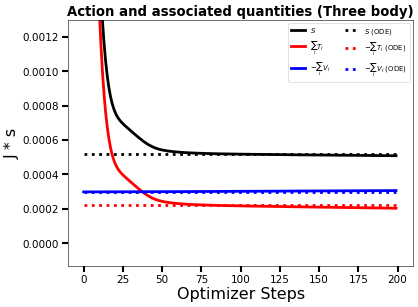

In [34]:
dt = 0.5 ; N = 3
t_sim, x_sim = simulate_3body(dt=dt)
init_path = PerturbedPath(x_sim, N=N, sigma=4e-2) # [time, N*2]
t_min, path, xs_min, info = minimize_action(init_path, steps=200, step_size=2e-3, L_fn=lagrangian_3body,
                                            dt=dt, opt='adam', print_updates=0, e_coeff=1e1)

name = 'Three body'
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fig = action_plot(info, x_sim, ax_labels, L_fn=lagrangian_3body)
plt.ylim(None, 0.0013)
path ='./static/{}_action.pdf'.format(name.lower().replace(' ', '')) ; print(path)
plt.show() #; fig.savefig(path)

## Gas simulation

In [ ]:
t, x = simulate_gas(dt=.5, N=50)

make_video(x, path='sim.mp4', interval=30)
mp4 = open('sim.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

In [ ]:
dt = 0.5 ; N = 50
t_sim, x_sim = simulate_gas(dt=dt, N=N)
init_path = PerturbedPath(x_sim, N=N, sigma=1e-2) # [time, N*2]
t_min, path, xs_min, info = minimize_action(init_path, steps=500, step_size=1e1,
                                       L_fn=lagrangian_gas, dt=dt, opt='sgd')

In [ ]:
N = x_sim.shape[-2]
xs_before = xs_min[0].detach().numpy().reshape(-1,N,2)
xs_after = xs_min[-1].detach().numpy().reshape(-1,N,2)

k = 25
plt.figure(dpi=100)
plt.title('Ball {} horiz. velocity vs. time'.format(1 + k//2))
plt.plot((xs_before[1:] - xs_before[:-1]).reshape(-1,N*2)[...,k], '.-', label='Initial path')
plt.plot((xs_after[1:] - xs_after[:-1]).reshape(-1,N*2)[...,k], '.-', label='Minimum action')
plt.plot((x_sim[1:] - x_sim[:-1]).reshape(-1,N*2)[...,k], 'k-', label='Simulator')
plt.legend()
plt.show()

In [ ]:
xs = xs_min[0].detach().numpy().reshape(-1,N,2)
make_video(xs, path='sim.mp4', interval=30, ms=10)
mp4 = open('sim.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

In [ ]:
xs = xs_min[-1].detach().numpy().reshape(-1,N,2)
make_video(xs, path='sim.mp4', interval=30, ms=10)
mp4 = open('sim.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

In [ ]:
name = 'Gas'
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fig = action_plot(info, x_sim, ax_labels, L_fn=lagrangian_3body)
# plt.ylim(None, 0.001)
path ='./static/{}_action.pdf'.format(name.lower().replace(' ', '')) ; print(path)
plt.show() #; fig.savefig(path)

## Ephemeris dataset and simulation

In [ ]:
planets = ['sun', 'mercury', 'venus', 'earth', 'mars']
data_dir = './data/'
df = process_raw_ephemeris(planets, data_dir, last_n_days=365) #365

t_sim, x_sim = simulate_planets(df, planets)
plot_planets(df, planets)

colors = get_planet_colors()
for i, (planet, coords) in enumerate(zip(planets, x_sim.transpose(1,2,0))):
    x, y = coords
    plt.plot(x, y, ':', alpha=0.5, color=colors[planet], label=planets[i] + ' (sim)')
    plt.plot(x[0], y[0], '+', color=colors[planet])
    plt.plot(x[-1], y[-1], 'x', color=colors[planet])
plt.axis('equal')
plt.legend(fontsize=6,  loc='upper right', ncol=2) ; plt.show()

In [ ]:
dt = 24*60*60 ; N = len(planets)
df = process_raw_ephemeris(planets, data_dir, last_n_days=365)
t_sim, x_sim = simulate_planets(df, planets, dt=dt)
init_path = PerturbedPath(x_sim, N=N, sigma=2e10, is_ephemeris=True) # [time, N*2]

L_planets = partial(lagrangian_planets, masses=get_masses(planets))

t_min, path, xs_min = minimize_action(init_path, steps=500, step_size=1e9,
                                       L_fn=L_planets, dt=dt, opt='adam')

In [ ]:
plt.figure(figsize=[5,3], dpi=120)
plt.title('Earth y coordinate')
xs_sim = init_path.x_true
xs_init = xs_min[0].detach().numpy().reshape(-1,N,2)
xs_final = xs_min[-1].detach().numpy().reshape(-1,N,2)
plt.plot(xs_sim[:,2,1], '--', label='sim')
plt.plot(xs_init[:,2,1], alpha=0.5, label='init')
plt.plot(xs_final[:,2,1], alpha=0.5, label='final')
plt.legend()

In [ ]:
fig = plt.figure(figsize=[5,5], dpi=140)
plot_planets(df, planets, fig=fig)
colors = get_planet_colors()

xs = xs_min[0].detach().numpy().reshape(-1,N,2)
for i, (planet, coords) in enumerate(zip(planets, xs.transpose(1,2,0))):
    x, y = coords
    plt.plot(x, y, '.', alpha=0.3, color=colors[planet], label=planets[i] + ' (init)')
    plt.plot(x[0], y[0], '+', color=colors[planet])
    plt.plot(x[-1], y[-1], 'x', color=colors[planet])
    
xs = xs_min[-1].detach().numpy().reshape(-1,N,2)
for i, (planet, coords) in enumerate(zip(planets, xs.transpose(1,2,0))):
    x, y = coords
    plt.plot(x, y, ':', alpha=0.5, color=colors[planet], label=planets[i] + ' (path)')

plt.axis('equal')
plt.legend(fontsize=6,  loc='upper right', ncol=3) ; plt.show()